In [4]:
#Import Required Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
#Import watershed-aggregated livestock tables
chickens_broilers_total = pd.read_csv('Data/Selected/Watershed/ChickensBroilers.csv', dtype = 'str')
chickens_layers_total = pd.read_csv('Data/Selected/Watershed/ChickensLayers.csv', dtype = 'str')
cows_beef_total = pd.read_csv('Data/Selected/Watershed/CowsBeef.csv', dtype = 'str')
cows_milk_total = pd.read_csv('Data/Selected/Watershed/CowsMilk.csv', dtype = 'str')
hogs_total = pd.read_csv('Data/Selected/Watershed/Hogs.csv', dtype = 'str')

In [6]:
#Create Lists of all watersheds and all years across all dataframes
all_ws = []
all_ys = []

for df in [chickens_broilers_total,
          chickens_layers_total,
          cows_beef_total,
          cows_milk_total,
          hogs_total]:
    all_ws.extend(df['HUC'].unique())
    all_ys.extend(df['YEAR'].unique())
    df['total'] = df['total'].astype('float') #Recast 'total' column as float

all_ws = list(set(all_ws))
all_ys = list(set(all_ys))

In [118]:
total_df = pd.DataFrame()

for huc in all_ws:
    ws_df = pd.DataFrame(all_ys, columns = ['YEAR']).sort_values(by = 'YEAR')
    ws_df['HUC'] = huc
    total_df = pd.concat([total_df, ws_df])

total_df = total_df.merge(
    chickens_broilers_total, 
    on = ['YEAR', 'HUC'], 
    how = 'outer'
).rename(
    columns = {'total' :'chickens_broilers_total'}
).merge(
    chickens_layers_total, 
    on = ['YEAR', 'HUC'], 
    how = 'outer'
).rename(
    columns = {'total' :'chickens_layers_total'}
).merge(
    cows_beef_total, 
    on = ['YEAR', 'HUC'], 
    how = 'outer'
).rename(
    columns = {'total' :'cows_beef_total'}
).merge(
    cows_milk_total, 
    on = ['YEAR', 'HUC'], 
    how = 'outer'
).rename(
    columns = {'total' :'cows_milk_total'}
).merge(
    hogs_total, 
    on = ['YEAR', 'HUC'], 
    how = 'outer'
).rename(
    columns = {'total' :'hogs_total'}
)

In [119]:
total_df['chickens_broilers_total'] = total_df.fillna(method = 'pad')['chickens_broilers_total'] * (14.97 / 455)
total_df['chickens_layers_total'] = total_df.fillna(method = 'pad')['chickens_layers_total'] * (11.45 / 250)
total_df['cows_beef_total'] = total_df.fillna(method = 'pad')['cows_beef_total'] * (11.5 / 1)
total_df['cows_milk_total'] = total_df.fillna(method = 'pad')['cows_milk_total'] * (15.24 / 0.74)
total_df['hogs_total'] = total_df.fillna(method = 'pad')['hogs_total'] * (14.69 / 9.09)

total_df['total_waste'] = total_df['chickens_broilers_total'] + total_df['chickens_layers_total'] + total_df['cows_beef_total'] + total_df['cows_milk_total'] + total_df['hogs_total']

In [9]:
total_df[['YEAR','HUC','total_waste']].rename(columns = {'total_waste': 'total'}).to_csv("Data/Selected/Watershed/TotalWaste.csv")

In [10]:
import PlotMaps
PlotMaps.watersheds_map("Data/Selected/Watershed/TotalWaste.csv", "Total Livestock Waste, Tons per Year", density = False, quantile = 0.999)

TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.025477600215197 41.213282665195379 at -73.025477600215197 41.213282665195379


In [11]:
colors_dict = {
    'chickens_broilers_total': 'tab:blue', 
    'chickens_layers_total': 'tab:orange', 
    'cows_beef_total': 'tab:green',
    'cows_milk_total': 'tab:red',
    'hogs_total': 'tab:purple'
}

In [12]:
for huc in total_df.groupby('HUC')['total_waste'].max().sort_values(ascending = False).head(10).index:
    plt.figure(figsize = (10, 7))
    plt.title(f"Tons Waste Per Year in Watershed {huc}")
    plt.stackplot(total_df.loc[total_df['HUC'] == huc, 'YEAR'],
                  total_df.loc[total_df['HUC'] == huc, 'chickens_broilers_total'],
                  total_df.loc[total_df['HUC'] == huc, 'chickens_layers_total'],
                  total_df.loc[total_df['HUC'] == huc, 'cows_beef_total'],
                  total_df.loc[total_df['HUC'] == huc, 'cows_milk_total'],
                  total_df.loc[total_df['HUC'] == huc, 'hogs_total'],
                 labels = [
                     'Broiler Chickens',
                     'Layer Chickens',
                     'Beef Cows',
                     'Milk Cows',
                     'Hogs'
                 ],
                 colors = colors_dict.values());
    plt.xticks(['1980', '1990', '2000', '2010', '2020'])
    plt.xlabel('Year')
    plt.ylabel("Tons Waste Per Year")
    plt.legend(loc = 'lower left')
    plt.savefig(f"Plots/Top10_{huc}.jpg")
    plt.close();

In [13]:
plt.figure(figsize = (14, 10))
plt.title("Proportions of Livestock Waste Among All Watersheds and Most Impacted Watersheds")
bottom_all = 0
bottom_top = 0
for column in ['chickens_broilers_total', 'chickens_layers_total', 'cows_beef_total', 'cows_milk_total', 'hogs_total']:
    
    plt.bar(x = ['All Watersheds'], height = total_df[column].sum(), bottom = bottom_all, label = column, color = colors_dict[column])
    bottom_all += total_df[column].sum()
    plt.bar(x = ['Most Impacted Watersheds'], height = total_df.loc[total_df['total_waste'] > total_df['total_waste'].quantile(0.9), column].sum(), bottom = bottom_top, color = colors_dict[column])
    bottom_top += total_df.loc[total_df['total_waste'] > total_df['total_waste'].quantile(0.9), column].sum()
plt.legend()
plt.ylabel("Annual Tons of Waste")
plt.savefig("Plots/AnimalProportions.jpg")
plt.close();

In [14]:
for year in total_df['YEAR'].unique():
    plt.figure(figsize = (12,9))
    plt.hist(total_df.loc[total_df['YEAR'] == year, 'total_waste'], bins = 70, label = f'{year} Distribution')
    plt.hist(total_df.loc[total_df['YEAR'] == '2020', 'total_waste'], bins = 70, histtype = 'step', color = 'grey', label = '2020 Distribution')
    plt.plot((total_df.loc[total_df['YEAR'] == '1980', 'total_waste'].median(), total_df.loc[total_df['YEAR'] == year, 'total_waste'].median()), (0, 70), color = 'k', linestyle = '--', label = f'{year} Median')
    plt.xlim(0, total_df['total_waste'].max())
    plt.ylim(0, 70)
    plt.title(f"Total Animal Waste Per Watershed, {year}")
    plt.xlabel("Total Animal Waste Per Watershed, Tons per Year")
    plt.legend()
    plt.savefig(f"Plots/WasteHist{year}.jpg")
    plt.close();

In [15]:
total_df.iloc[total_df['total_waste'].idxmax()]

YEAR                              2014
HUC                             180300
chickens_broilers_total         512623
chickens_layers_total          8112.36
cows_beef_total                 739643
cows_milk_total            1.78479e+07
hogs_total                      199186
total_waste                1.93074e+07
Name: 4913, dtype: object

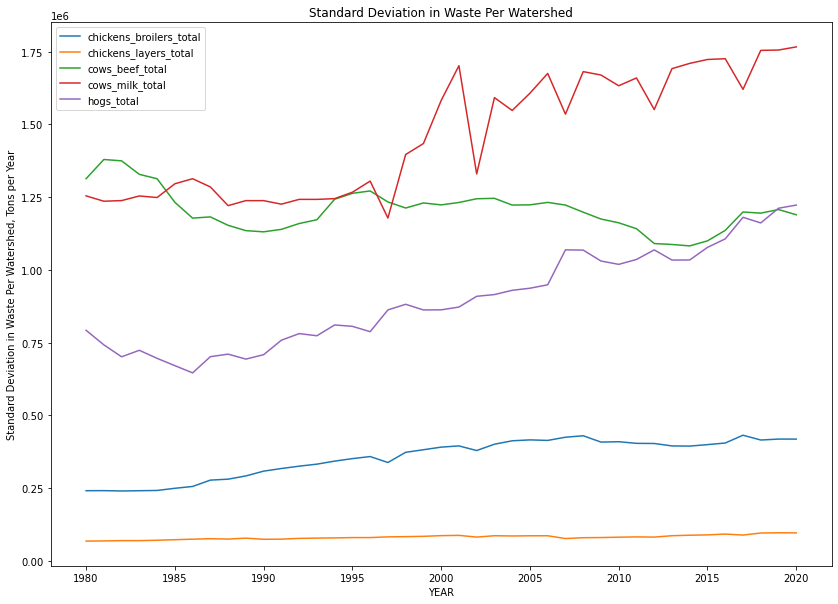

In [16]:
plt.figure(figsize = (14, 10))
plt.title("Standard Deviation in Waste Per Watershed")
for column in ['chickens_broilers_total', 'chickens_layers_total', 'cows_beef_total', 'cows_milk_total', 'hogs_total']:
    (total_df.groupby('YEAR')[column].std()).plot(color = colors_dict[column], label = column)
plt.legend()
plt.ylabel("Standard Deviation in Waste Per Watershed, Tons per Year")
plt.savefig("Plots/StandardDeviationTime.jpg")

In [22]:
epa = gpd.GeoDataFrame(pd.merge(left = gpd.read_file("Data/Sources/rad_303d_20150501_shp/rad_303d_20150501/", layer = 'attgeo_303dcaussrce').drop(columns = ['geometry']),
          right = gpd.read_file("Data/Sources/rad_303d_20150501_shp/rad_303d_20150501/", layer = 'rad_303d_a')[['ESRI_KEY', 'geometry', 'HUC12']],
          on = ['ESRI_KEY']))

epa['HUC'] = epa['HUC12'].str[:6]

n303d = epa[epa['LW_PARC_NM'] == 'NUTRIENTS'].groupby(['HUC', 'CYCLE_YEAR']).count()[['LIST_ID']].reset_index().rename(columns = {'LIST_ID': 'n303d', 'CYCLE_YEAR': 'YEAR'})

In [46]:
total_df = pd.merge(left = total_df[total_df['YEAR'].isin(n303d['YEAR'])],
        right = n303d,
        on = ['HUC', 'YEAR'],
        how = 'outer').dropna(subset = ['total_waste']).fillna(0)

In [49]:
total_df[total_df['n303d'] > 0]

,YEAR,HUC,chickens_broilers_total,chickens_layers_total,cows_beef_total,cows_milk_total,hogs_total,total_waste,n303d
19,2012,041503,260.481433,499.520645,9.394114e+04,1.286047e+06,3.266735e+03,1.384015e+06,61.0
24,2012,102702,2067.732539,82100.697810,1.978980e+06,1.665708e+06,1.033615e+06,4.762472e+06,26.0
32,2008,041000,12769.722064,307222.454413,6.778783e+05,1.842790e+06,1.473064e+06,4.313725e+06,461.0
39,2012,102500,180.536089,752.687398,4.940555e+06,3.606809e+06,1.220018e+06,9.768315e+06,14.0
40,2002,030902,170.858075,330.713478,1.597562e+06,1.765747e+05,4.167948e+03,1.778806e+06,235.0
...,...,...,...,...,...,...,...,...,...
1694,2012,110300,165.127843,57832.759040,2.750970e+06,6.119901e+06,4.656392e+05,9.394508e+06,38.0
1699,2012,102600,89.575515,2029.159728,3.941710e+06,2.178672e+06,3.713633e+05,6.493864e+06,27.0
1704,2012,130302,3.725912,34.554669,3.052571e+05,2.525579e+05,1.115097e+02,5.579648e+05,2.0
1714,2012,100500,377.542489,2726.986790,1.501363e+06,1.355349e+04,3.897155e+04,1.556992e+06,15.0


In [64]:
from scipy import stats

In [71]:
for column in ['chickens_broilers_total', 'chickens_layers_total', 'cows_beef_total', 'cows_milk_total', 'hogs_total']:
    print(column , stats.ttest_ind(total_df.loc[total_df['n303d'] > 0, column], total_df.loc[total_df['n303d'] == 0, column], equal_var=False)[1])

chickens_broilers_total 0.15932795543465628
chickens_layers_total 0.0070109787019392595
cows_beef_total 0.7028783376305809
cows_milk_total 0.08573982133159558
hogs_total 0.033036523628491715


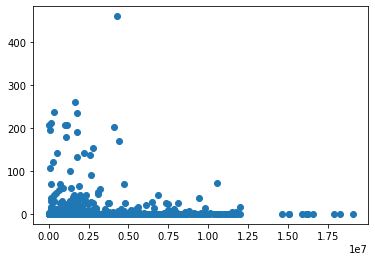

In [72]:
plt.scatter(total_df['total_waste'], total_df['n303d'])

In [74]:
hucs = gpd.read_file("Data/Sources/WBD_National_GDB.gdb", driver='FileGDB', layer='WBDHU6')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['iso_a3'] == 'USA']
usac = gpd.clip(usa, Polygon([(-130, 20), (-130, 55), (-60, 55), (-60, 20), (-130, 20)]))

hucs_clipped = hucs.copy()
for i in hucs_clipped.index:
    try:
        if gpd.clip(hucs_clipped.loc[[i]], usac).shape[0] == 0:
            hucs_clipped.drop(i, inplace = True)
        else:
            hucs_clipped.loc[[i]] = gpd.clip(hucs_clipped.loc[[i]], usac)
    except:
        pass

TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.025477600215197 41.213282665195379 at -73.025477600215197 41.213282665195379


In [76]:
total_df['YEAR'].unique()

array(['2002', '2004', '2008', '2010', '2012'], dtype=object)

In [99]:
huc12s = gpd.read_file("Data/Sources/WBD_National_GDB.gdb", driver='FileGDB', layer='WBDHU12')

In [105]:
epa = pd.merge(left = epa,
         right = huc12s[['HUC12', 'geometry']],
         on = 'HUC12',
         suffixes = ['_epa', '']).drop(columns = ['geometry_epa'])

In [127]:
fig, ax = plt.subplots(1, 1, figsize = (14, 12))
plt.title(f"Hog- and  Layer Chicken- Impacted Watersheds and 301(d) Listed Waters, 2002-2012")
hucs_clipped.boundary.plot(color = 'grey', linewidth = 0.1, ax = ax)

gdf = gpd.GeoDataFrame(pd.merge(left = total_df.loc[total_df['YEAR'].isin(epa['CYCLE_YEAR'].unique())].groupby(['HUC']).max().reset_index(),
right = hucs_clipped[['HUC6', 'geometry', 'AREASQKM']],
left_on = ['HUC'],
right_on = ['HUC6'],
how = 'inner'))

gdf.plot(column = 'hogs_total', legend = False, vmin = 0, vmax = total_df['hogs_total'].quantile(0.95), cmap = 'Purples', ax = ax, alpha = 0.5)

gdf.plot(column = 'chickens_broilers_total', legend = False, vmin = 0, vmax = total_df['chickens_broilers_total'].quantile(0.95), cmap = 'Oranges', ax = ax, alpha = 0.5)
epa[(epa['LW_PARC_NM'] == 'NUTRIENTS')].plot(ax = ax, color = 'cyan', zorder = 10)
ax.axis('off')
plt.tight_layout()
plt.savefig("Plots/Maps/HogsChickens301d.jpg")
plt.close()

In [122]:
epa[(epa['LW_PARC_NM'] == 'NUTRIENTS')].groupby('HUC12')

In [116]:
total_df.loc[total_df['YEAR'].isin(epa['CYCLE_YEAR'].unique())].groupby(['HUC']).mean().reset_index()

,HUC,chickens_broilers_total,chickens_layers_total,cows_beef_total,cows_milk_total,hogs_total,total_waste,n303d,cluster
0,010100,60.530114,189.122903,23208.154459,41171.250513,935.842987,65564.900976,0.0,0.0
1,010200,278.750149,325.856934,16185.526950,173688.568119,1285.988368,191764.690521,0.0,0.0
2,010300,99.071533,627.352179,28237.270044,252758.993463,2156.187935,283878.875155,0.0,0.0
3,010400,82.197068,179.847656,20954.322458,105303.550609,1645.642416,128165.560206,0.0,0.0
4,010500,295.704900,1232.528810,18321.982999,78562.715529,1322.824777,99735.757015,0.0,0.0
...,...,...,...,...,...,...,...,...,...
342,200400,1.953737,58.621225,17427.901161,207.421985,877.089921,18572.988029,0.0,0.0
343,200500,3.237993,97.154864,28883.827907,343.767207,1453.629676,30781.617648,0.0,0.0
344,200600,3.846311,9829.310466,12591.172382,14477.623180,9882.580556,46784.532895,0.0,0.0
345,200700,1.947596,166.845432,47118.624877,3862.640913,2156.365339,53306.424157,0.0,0.0
